In [1]:
from pathlib import Path
from glob import glob

In [2]:
import datasets
from datasets import load_dataset

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np
import pandas as pd

In [4]:
participants = [Path(path).stem for path in glob('./data/ecg_preprocessed/*.csv')]

In [5]:
dataset = load_dataset(
    './data/ecg_preprocessed', 
    data_files=[participants[0] + '.csv'],
    trust_remote_code=True
)['train']

# T-Wave

In [6]:
import neurokit2 as nk

In [7]:
window = dataset[0:0+(60 * 1000)]

In [8]:
_, rpeaks = nk.ecg_peaks(window['ECG_Clean'], sampling_rate=1000)

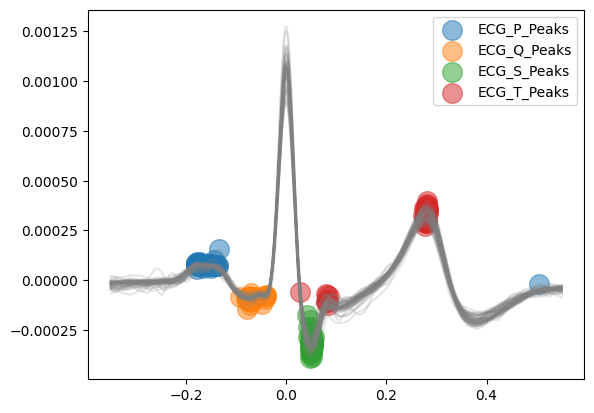

In [9]:
signals, waves = nk.ecg_delineate(window['ECG_Clean'], 
    rpeaks, 
    sampling_rate=1000, 
    method="cwt", 
    show=True, 
    show_type='peaks'
)

In [10]:
df = pd.DataFrame(window)
t_wave = df.loc[(df['ECG_T_Onsets'] == 1) | (df['ECG_T_Peaks'] == 1) | (df['ECG_T_Offsets'] == 1)]

In [11]:
df = pd.DataFrame(window)
t_waves = []
for idx_start, idx_end in zip(waves['ECG_T_Onsets'], waves['ECG_T_Offsets']):
    t_wave = df.loc[idx_start:idx_end]
    t_waves.append(t_wave)
t_waves = pd.concat(t_waves)

In [12]:
t_amplitudes = t_waves.loc[(df['ECG_T_Peaks'] == 1)]['signal']

FFFT

In [13]:
from scipy.fft import fft, ifft, fftfreq

In [14]:
import matplotlib.pyplot as plt

In [15]:
yf = fft(list(t_waves['ECG_Clean']))
xf = fftfreq(len(t_waves['ECG_Clean']), 1/1000)

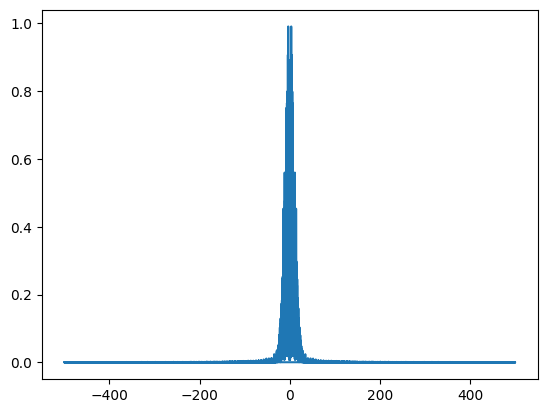

In [16]:
plt.plot(xf, np.abs(yf))
plt.show()

## MMAM

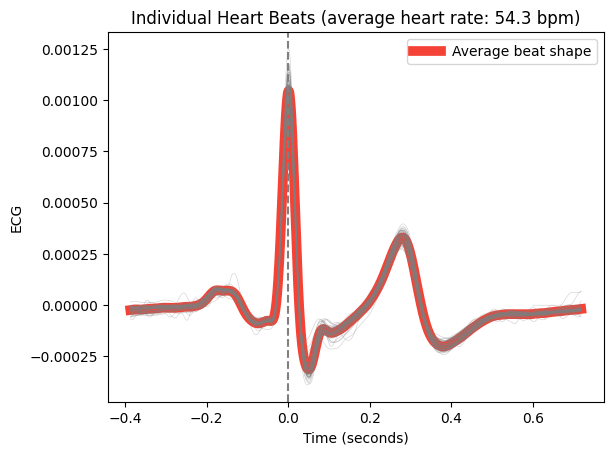

In [37]:
epochs = nk.ecg_segment(df["ECG_Clean"], rpeaks=rpeaks['ECG_R_Peaks'], sampling_rate=1000, show=True)

In [38]:
heartbeats = nk.epochs_to_df(epochs)
heartbeats.head()

,Signal,Index,Label,Time
0,0.000015,400,1,-0.387010
1,0.000015,401,1,-0.386010
2,0.000016,402,1,-0.385009
3,0.000016,403,1,-0.384008
4,0.000017,404,1,-0.383008


In [39]:
pivoted = heartbeats.pivot(index='Time', columns='Label', values='Signal')
pivoted.head()

Label,1,10,11,12,13,14,15,16,17,18,...,5,50,51,52,53,54,6,7,8,9
Time,,,,,,,,,,,,,,,,,,,,,
-0.387010,0.000015,-0.000044,-0.000044,-0.000054,-0.000052,-0.000046,-0.000058,-0.000045,-0.000031,-0.000025,...,-0.000028,-0.000033,-0.000044,-0.000034,-0.000024,NaN,-0.000034,-0.000070,-0.000022,-0.000016
-0.386010,0.000015,-0.000044,-0.000041,-0.000054,-0.000052,-0.000045,-0.000058,-0.000044,-0.000031,-0.000025,...,-0.000027,-0.000033,-0.000044,-0.000031,-0.000024,NaN,-0.000033,-0.000071,-0.000021,-0.000014
-0.385009,0.000016,-0.000044,-0.000038,-0.000054,-0.000052,-0.000045,-0.000058,-0.000043,-0.000030,-0.000025,...,-0.000026,-0.000033,-0.000044,-0.000029,-0.000024,NaN,-0.000032,-0.000072,-0.000020,-0.000012
-0.384008,0.000016,-0.000044,-0.000035,-0.000054,-0.000053,-0.000044,-0.000058,-0.000042,-0.000030,-0.000024,...,-0.000025,-0.000033,-0.000044,-0.000027,-0.000025,NaN,-0.000030,-0.000072,-0.000019,-0.000011
-0.383008,0.000017,-0.000044,-0.000033,-0.000053,-0.000052,-0.000043,-0.000057,-0.000041,-0.000030,-0.000024,...,-0.000024,-0.000033,-0.000044,-0.000024,-0.000025,NaN,-0.000029,-0.000072,-0.000019,-0.000010


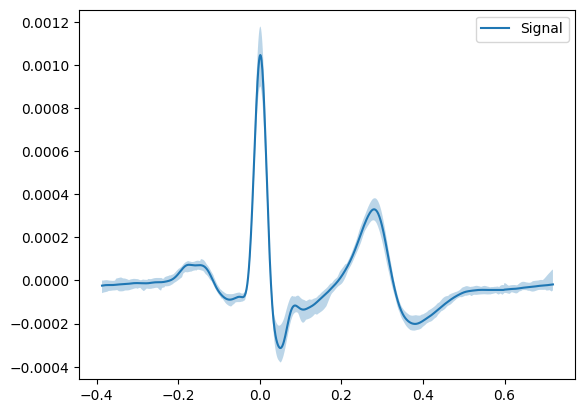

In [40]:
grand_av = nk.epochs_average(epochs, which="Signal", show=True)

<Axes: >

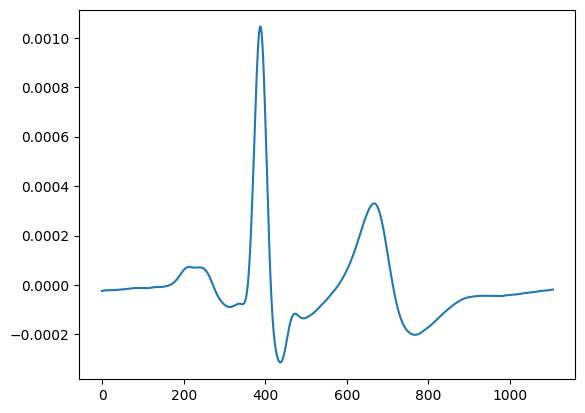

In [65]:
grand_av['Signal_Mean'].plot()

In [73]:
nk.ecg_findpeaks(grand_av['Signal_Mean'])['ECG_R_Peaks']

array([388])

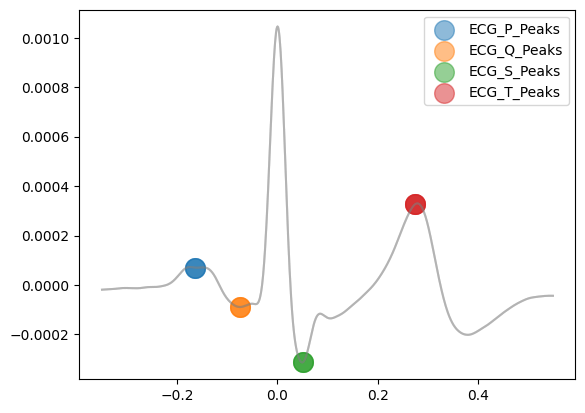

In [94]:
signals_grand, waves_grand = nk.ecg_delineate(list(grand_av['Signal_Mean']) + list(grand_av['Signal_Mean']) + list(grand_av['Signal_Mean']) + list(grand_av['Signal_Mean']), 
    rpeaks=None, 
    sampling_rate=1000, 
    show=True, 
    show_type='peaks' 
)

In [148]:
waves_grand['ECG_T_Peaks'][0]

662

In [102]:
t = signals_grand[:len(grand_av)]
t

,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1101,0,0,0,0,0,0,0,0,0,0
1102,0,0,0,0,0,0,0,0,0,0
1103,0,0,0,0,0,0,0,0,0,0
1104,0,0,0,0,0,0,0,0,0,0


In [105]:
t[t['ECG_T_Peaks'] == 1].index[0]

662

In [107]:
grand_av.iloc[t[t['ECG_T_Peaks'] == 1].index[0]]

index             662.000000
Time                0.275435
Signal_Mean         0.000326
Signal_SD           0.000028
Signal_CI_low       0.000278
Signal_CI_high      0.000374
Name: 662, dtype: float64

In [280]:
import math 

def _get_average_t(epochs, sampling_rate=1000):
    try:
        average = nk.epochs_average(epochs, which="Signal")

        min_length = sampling_rate * 4
        n = len(average)
        # Unfortunately, NeuroKit is unable to detect the P-QRST-T peaks on a single heartbeat. It requires multiple, so let's just repeat the signal to satisfy the minimum length required.
        signal = np.concatenate( [list(average['Signal_Mean']) for _ in range(math.ceil(min_length / n))])

        _, waves_grand = nk.ecg_delineate(signal, rpeaks=None, method='peak', sampling_rate=sampling_rate)
        t_index = waves_grand['ECG_T_Peaks'][0]

        if np.isnan(t_index):
            return np.nan
        else:
            return signal[t_index]
    except:
        return np.nan

def modified_moving_average(signal, sampling_rate=1000):
    epochs = nk.ecg_segment(signal, rpeaks=None, sampling_rate=sampling_rate)

    if len(epochs) % 2 != 0:
        # We want balanced buckets, so pop the last item to make it even.
        epochs.popitem()
    
    even_keys = list(epochs.keys())[1::2]
    odd_keys = list(epochs.keys())[::2]

    even_bucket = {key: epochs[key] for key in even_keys}
    odd_bucket = {key: epochs[key] for key in odd_keys}

    average_t_even = _get_average_t(even_bucket, sampling_rate)
    average_t_odd = _get_average_t(odd_bucket, sampling_rate)

    if average_t_even is None or average_t_odd is None:
        return np.nan
    else:
        twa = abs(average_t_even - average_t_odd)
        return twa

In [277]:
modified_moving_average(window['ECG_Clean'])

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


## Per Category?

In [251]:
from scipy import stats

In [252]:
window_size = 60 * 1000

In [285]:
twas = []
for idx in range(0, len(dataset), window_size):
    window = dataset[idx:idx+window_size]
    twa = modified_moving_average(window['ECG_Clean'])
    if twa is None:
        continue
    label = max(set(window['category']), key=window['category'].count)
    twas.append({ 'twa': twa, 'category': label })

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning em

In [289]:
t = pd.DataFrame(twas).fillna(0)
t.head()

,twa,label
0,2.014674e-06,0
1,2.917817e-06,Lying_supine
2,5.828952e-07,Lying_supine
3,2.612140e-07,Lying_supine
4,2.854199e-06,Lying_supine


In [290]:
baseline = ['Sitting', 'Recov1', 'Recov2', 'Recov3', 'Recov4', 'Recov5', 'Recov6']
mental_stress = ['TA', 'SSST_Sing_countdown', 'Pasat', 'Raven', 'TA_repeat', 'Pasat_repeat']
high_physical_stress = ['Treadmill1', 'Treadmill2', 'Treadmill3', 'Treadmill4', 'Walking_fast_pace', 'Cycling', 'stairs_up_and_down']
moderate_physical_stress = ['Walking_own_pace', 'Dishes', 'Vacuum']
low_physical_stress = ['Standing', 'Lying_supine', 'Recov_standing']

In [318]:
for category in baseline:
    t.loc[t['category'] == category, 'label'] = 0
for category in mental_stress:
    t.loc[t['category'] == category, 'label'] = 1
for category in high_physical_stress:
    t.loc[t['category'] == category, 'label'] = 2
for category in moderate_physical_stress:
    t.loc[t['category'] == category, 'label'] = 0
for category in low_physical_stress:
    t.loc[t['category'] == category, 'label'] = 0

In [303]:
t

,twa,category,label
0,2.014674e-06,0,NaN
1,2.917817e-06,Lying_supine,4.0
2,5.828952e-07,Lying_supine,4.0
3,2.612140e-07,Lying_supine,4.0
4,2.854199e-06,Lying_supine,4.0
...,...,...,...
140,0.000000e+00,Recov6,0.0
141,0.000000e+00,Recov6,0.0
142,0.000000e+00,Recov6,0.0
143,1.095985e-08,Recov6,0.0


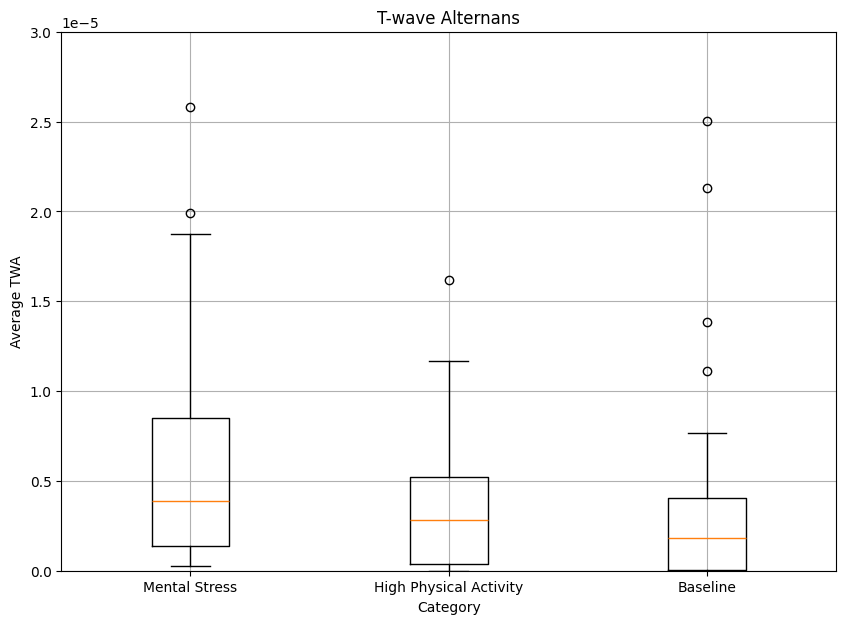

In [326]:
fig, ax=plt.subplots(figsize=(10,7))
ax.boxplot([
    t[t['label'] == 1]['twa'],
    t[t['label'] == 2]['twa'], 
    t[t['label'] == 0]['twa']
], labels=['Mental Stress', 'High Physical Activity', 'Baseline'])
ax.set_title(f'T-wave Alternans')
ax.set_xlabel('Category')
ax.set_ylabel(f'Average TWA')
ax.set_ylim(0, 0.00003)
plt.savefig(f'./public/twa.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.grid()
plt.show()

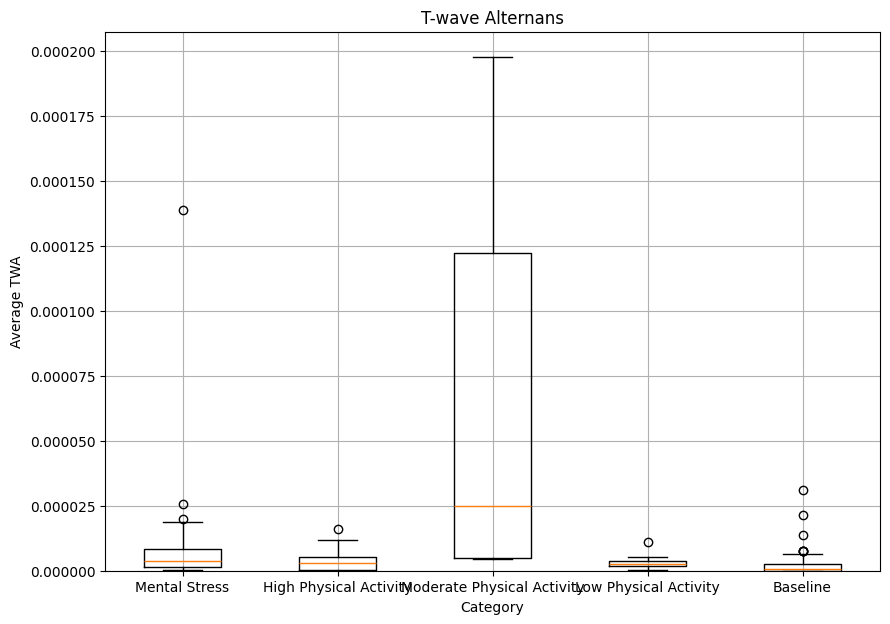

In [317]:
fig, ax=plt.subplots(figsize=(10,7))
ax.boxplot([
    t[t['label'] == 1]['twa'],
    t[t['label'] == 2]['twa'], 
    t[t['label'] == 3]['twa'], 
    t[t['label'] == 4]['twa'], 
    t[t['label'] == 0]['twa']
], labels=['Mental Stress', 'High Physical Activity', 'Moderate Physical Activity', 'Low Physical Activity', 'Baseline'])
ax.set_title(f'T-wave Alternans')
ax.set_xlabel('Category')
ax.set_ylabel(f'Average TWA')
ax.set_ylim(0)
plt.savefig(f'./public/twa_all.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.grid()
plt.show()